# Interpretable Machine Learning
## Exercise Sheet: 8 Gradient-based Explanations
### Presentation date: 08.01.2023

Gradient-based approaches are among the most popular methods used for interpreting neural networks.
They leverage white-box access to the neural network, as they rely on backpropagation to compute the
gradients of an input with respect to a prediction. The intuition behind using gradients for explanatory
purposes is that they tell us, how sensitive the prediction is to small changes in the input. In this assignment,
we will generate different gradient-based explanations for a ResNet18 model pretrained on the ImageNet
Dataset by 1) applying off-the-shelf methods and 2) implementing gradient-based feature attribution from
scratch.

Please also download the other files from the studIP/Github folder, because we will use some preimplemented methods from those folders and the test_image for demonstration.

In [1]:
#!pip install torch
#!pip install torchvision
#!pip install captum

In [2]:
import torch
import torchvision
from utils.styled_plot import plt
from utils.dataset import load_test_image, preprocess_image, normalize_image, convert_idx_to_label
from classifiers.cnn_classifier import ImageNetClassifier
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

### Excercise 1: Applying Gradient-based Feature Attribution Methods

In this first task, the goal is to use off-the-shelf implementations of different gradient-based feature attribution
methods to obtain explanations. Here, we apply different methods implemented in `Captum`, a model
interpretability library for `PyTorch`.

#### 1.1 Gradient
Complete `get_gradient` to produce a saliency map based on the gradient with respect to the model’s prediction
as the target class, for a given input image. Use `captum.attr.Saliency`.

**Solution**

In [3]:
def get_gradient(model, image):
    """
    Uses captum's 'Saliency' method to generate a saliency map based on the gradient w.r.t. 
    the model's prediction as the target. See also: https://captum.ai/api/saliency.html

    Parameters:
        model (ImageNetClassifier): Image classification model. Has a 'predict' method that 
                                    returns the predicted label index for an image.
        image (torch.tensor): Single image with shape (1, 3, ?, ?).

    Returns:
        attribution (torch.tensor): The gradient, of the same shape as the image.
    """
    prediction = model.predict(image)
    saliency = Saliency(model)
    image.requires_grad = True
    attribution = saliency.attribute(image, target=prediction)
    return attribution.detach()

#### 1.2 Integrated Gradients
The Integrated Gradients method interpolates gradients between a non-informative baseline $\bar{x}$ and the actual input $x$. Complete `get_integrated_gradients` to produce the Integrated Gradients with respect to the model’s prediction as the target class, for a given input image. Use `captum.attr.IntegratedGradients`.

In [4]:
def get_integrated_gradients(model, image):
    """
    Uses captum's IntegratedGradients method to generate an attribution map w.r.t. the model's prediction as the target. 
    Uses zeros (black image) as the baseline, that are normalized using 'normalize_image'.
    See also: https://captum.ai/api/integrated_gradients.html

    Parameters:
        model (ImageNetClassifier): Image classification model. Has a 'predict' method that returns the predicted label index 
                                    for an image.
        image (torch.tensor): Single image with shape (1, 3, ?, ?).

    Returns:
        attributions (torch.tensor): The integrated gradients, of the same shape as the image.
    """
    prediction = model.predict(image)
    ig = IntegratedGradients(model)
    baseline = torch.zeros_like(image)
    baseline = normalize_image(baseline)
    attribution = ig.attribute(image, target=prediction, baselines=baseline)
    return attribution.detach()

#### 1.3 SmoothGrad
The SmoothGrad method helps to reduce noise by adding noise. Complete `get_smoothgrad` to produce a
smoothed saliency map for a given input image. Use `captum.attr.NoiseTunnel` in combination with `captum.attr.Saliency`.

In [5]:
def get_smoothgrad(model, image, num_samples=10, stdevs=0.3):
    """
    Uses captum's NoiseTunnel and Saliency method to generate a saliency map using SmoothGrad, based on the gradient w.r.t. 
    the model's prediction as the target. See also: https://captum.ai/api/noise_tunnel.html

    Parameters:
        model (ImageNetClassifier): Image classification model. Has a 'predict' method.
        image (torch.tensor): Single image with shape (1, 3, ?, ?).
        num_samples (int): Number of SmoothGrad samples to use.
        stdevs (float): Standard deviation for the smoothgrad samples

    Returns:
        attributions (torch.tensor): The gradient, of the same shape as the image.
    """
    prediction = model.predict(image)
    saliency = Saliency(model)
    nt = NoiseTunnel(saliency)
    attribution = nt.attribute(image, target=prediction, nt_samples=num_samples, stdevs=stdevs)
    return attribution.detach()


#### 1.4 Preparing Feature Attribution Maps for Visualization
The resulting feature attribution maps have the same dimensions as the input to the neural network. For
visualization purposes, we often aggregate them to smaller dimensions to produce heatmap-like outputs.
Complete `aggregate_attribution` that aggregates an attribution map with three color channels to a single
color channel by summing over the channel dimension.
For proper visualization, we additionally want to normalize the attribution maps. Complete `normalize_attribution` that first takes the absolute values of the attributions, then normalizes them into the range
[0, 1] by subtracting the minimum and afterwards dividing by the maximum.

In [6]:
def aggregate_attribution(attribution):
    """
    Aggregates the channel dimension of a feature attribution tensor via summation.
    Additionally, removes the batch dimension (dim 0).

    Parameters:
        attribution (torch.tensor): Feature attribution of shape (1, 3, ?, ?)

    Returns:
        attribution (torch.tensor): The aggregated attribution of shape (?, ?)
    """
    return attribution.sum(1).squeeze()

In [7]:
def normalize_attribution(attribution):
    """
    Takes the absolute value of the feature attribution, then normalizes to the range [0, 1] by first subtracting the minimum 
    and then dividing by the maximum afterwards.

    Parameters:
        attribution (torch.tensor): Feature attribution of shape (?, ?)

    Returns:
        attribution (torch.tensor): The absolute, normalized attribution of shape (?, ?)
    """
    attribution = attribution.abs()
    attribution -= attribution.min()
    attribution /= attribution.max()
    return attribution

#### 1.5 Visualizing Feature Attributions
After generating all the explanations, we of course want to plot them. Complete the `plot_attributions`
function that plots the image and the generated attributions in a row.

In [8]:
def plot_attributions(plt, image, attributions, method_names):
    """
    Visualizes an image and a list of corresponding feature attributions by plotting them in a single row.

    Parameters:
        image (torch.tensor): Single image with shape (3, ?, ?)
        attributions (List[torch.tensor]): List of feature attributions, each of shape (?, ?)
        method_names (List[str]): List of method names corresponding to the attributions. Used as subfigure titles.

    Returns:
        None

    Hint: iterate over the axes. Use imshow() to plot images. Matplotlib expects a channels last format. Optionally turn of 
    the axis labeling using ax.axis('off') .
    """
    fig, axes = plt.subplots(len(attributions) + 1, 1)

    axes[0].set_title('Image')
    test = image.permute(1,2,0).numpy()
    axes[0].imshow(image.permute(1,2,0).numpy(), cmap='viridis')
    axes[0].axis('off')

    for i, ax in enumerate(axes[1:]):
        ax.imshow(attributions[i].numpy(), cmap='viridis')
        ax.set_title(method_names[i])
        ax.axis('off')

#### 1.6. Example
Apply the explanation methods on the test_image.png and plot the results. As a model we use ImageNetClassifier. Interpret your results.

Predicted class: "junco, snowbird". Confidence: 94.83%
Run `get_gradient` ...
Run `get_integrated_gradients` ...
Run `get_smoothgrad` ...
Run `plot_attributions` ...


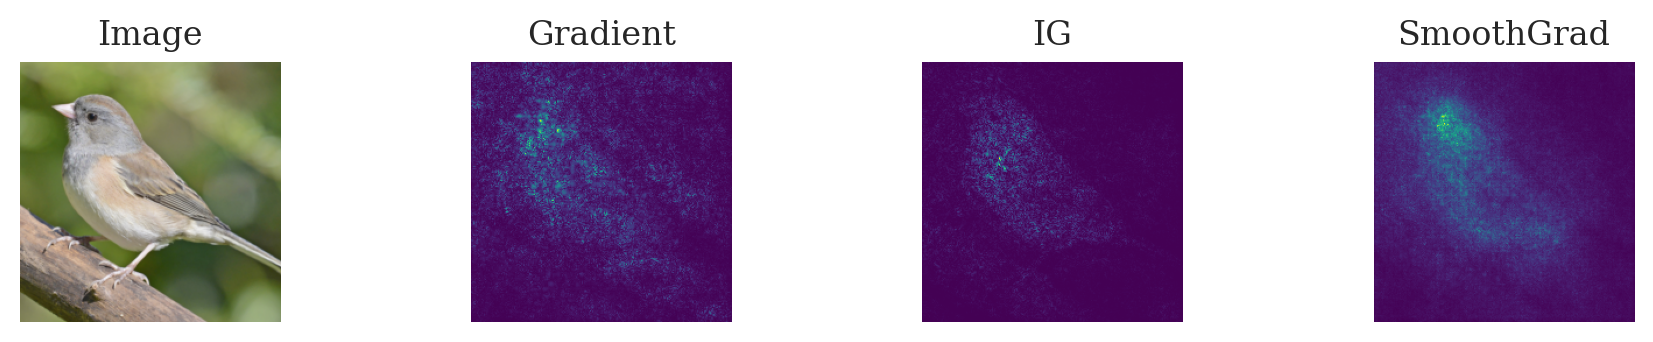

In [9]:
image = load_test_image()
image_preprocessed = preprocess_image(image)
image_preprocessed_norm = normalize_image(image_preprocessed).unsqueeze(0)

model = ImageNetClassifier()

y_pred, y_prob = model.predict(image_preprocessed_norm, return_probs=True)
print(f'Predicted class: "{convert_idx_to_label(y_pred.item())}". Confidence: {y_prob.item() * 100:.2f}%')

print('Run `get_gradient` ...')
gradient = get_gradient(model, image_preprocessed_norm)

print('Run `get_integrated_gradients` ...')
ig = get_integrated_gradients(model, image_preprocessed_norm)

print('Run `get_smoothgrad` ...')
smoothgrad = get_smoothgrad(model, image_preprocessed_norm)

print('Run `plot_attributions` ...')
attributions = [gradient, ig, smoothgrad]
attributions = [aggregate_attribution(attr) for attr in attributions]
attributions = [normalize_attribution(attr) for attr in attributions]
plot_attributions(plt, image_preprocessed, attributions, ['Gradient', 'IG', 'SmoothGrad'])
plt.show()

### 2 Gradient-based Feature Attribution from Scratch
Now, the task is to implement the methods from task 1 from scratch.

#### 2.1 Saliency Maps 

Complete `get_custom_gradient` that implements the simple gradient method to compute a feature attribution
map:

\begin{align}
A= \frac{\partial f(\bf{x})_c}{\partial \bf{x}}
\end{align}

where $A$ is the resulting feature attribution map, f is the neural network model, x is an input image and $c$
is the index of the class we are interested in. That means $f(\bf{x})_c$ is the neural network output corresponding
to class $c$. Here, the class we are interested in is the one that is predicted by the model.

In [10]:
def get_custom_gradient(model, image, absolute=False):
    """
    Generates a saliency map based on the input gradient w.r.t. the model's prediction as the target.

    Parameters:
        model (ImageNetClassifier): Image classification model. Has a 'predict' method that returns the predicted label 
                                    index for an image.
        image (torch.tensor): Single image with shape (1, 3, ?, ?).
        absolute (bool): If True, return the absolute value of the gradients. If False, return the signed gradients.

    Returns:
        attribution (torch.tensor): The gradient, of the same shape as the image.

    Hint: Use torch.autograd.grad . The model is a torch.nn.Module, so you can call model(x) to get the network's outputs.
    """
    prediction = model.predict(image)
    image.requires_grad = True
    output = model(image)
    grad = torch.autograd.grad(output[:, prediction], image)[0]
    if absolute:
        grad = grad.abs()
    return grad.detach()

#### 2.2. Integrated Gradients
Now we want to implement the Integrated Gradients method from scratch.

#### 2.2.1 Path Computation
First, complete the `get_path` function, that creates a path of images. The path starts from a baseline, ends
with the actual image and is filled with intermediate samples in between. This path essentially contains the
samples

\begin{align}
\tilde{x}_{\alpha} = \bar{x} + \alpha (x-\bar{x})
\end{align}
for increasing $\alpha \in [0,1]$ such that you obtain a series of $\tilde{x}_{\alpha}$ as discussed in the lecture. The alphas should
be evenly spaced in the unit interval. Here, we choose a black image as the baseline $\bar{x}$.

In [11]:
def get_path(image, baseline, num_samples):
    """
    Generate an attribution map based on the Integrated Gradients method, w.r.t. the model's prediction.
    Uses zeros (black image) as the baseline, that are normalized using 'normalize_image'.

    Parameters:
        image (torch.tensor): Single image with shape (1, 3, ?, ?).
        baseline (torch.tensor): Baseline image with same shape as image.
        num_samples (int): The number of samples on the path.

    Returns:
        path (List[torch.tensor]): A list of length num_samples, containing the images on the path starting from the 
        baseline (path[0]) and ending with the image (path[-1]).

    Hint: Create alphas using torch.linspace.
    """
    alphas = torch.linspace(0, 1, num_samples)
    path = [baseline + alpha * (image-baseline) for alpha in alphas]
    return path

#### 2.2.2 Integrated Gradient Computation
Next, complete `get_custom_integrated` gradients to generate the integrated gradients using the following
equation:

\begin{align}
A=(x-\bar{x})\int_{\alpha=0}^1 \frac{\partial f(\bf{x})_c}{\partial \tilde{\bf{x}}}\Bigg|_{ \tilde{\bf{x}}=\bar{\bf{x}}+\alpha(\bf{x}-\bar{\bf{x}})}
\end{align}
where the integral is approximated by averaging the gradients over the samples in the path.

In [12]:
def get_custom_integrated_gradients(model, image, num_samples):
    """
    Generate an attribution map based on the Integrated Gradients method, w.r.t. the model's prediction.
    Uses zeros (black image) as the baseline, that are normalized using 'normalize_image'.

    Parameters:
        model (ImageNetClassifier): Image classification model. Has a 'predict' method that returns the predicted label 
                                    index for an image.
        image (torch.tensor): Single image with shape (1, 3, ?, ?).
        num_samples (int): The number of samples on the path.
    Returns:
        attributions (torch.tensor): The integrated gradients, of the same shape as the image.

    Hint: Iterate over the path of images, remember what you did in 'get_custom_gradient'.
    Use torch.autograd.grad . The model is a torch.nn.Module, so you can call model(x) to get the network's outputs.
    """
    prediction = model.predict(image)
    baseline = torch.zeros_like(image)
    baseline = normalize_image(baseline)
    path = get_path(image, baseline, num_samples)

    grads = []
    for p in path:
        p.requires_grad = True
        output = model(p)
        grad = torch.autograd.grad(output[:, prediction], p)[0]
        grads.append(grad)

    ig = (image - baseline) * (torch.cat(grads)).mean(0)
    return ig

#### 2.3. Example
Apply your implemented explanation methods on the test_image.png and plot the results. As a model we use ImageNetClassifier. Compare to task 1 and interpret your results. 

Predicted class: "junco, snowbird". Confidence: 94.83%
Run `get_custom_gradient` ...
Run `get_custom_integrated_gradients` ...
Run `plot_attributions` ...


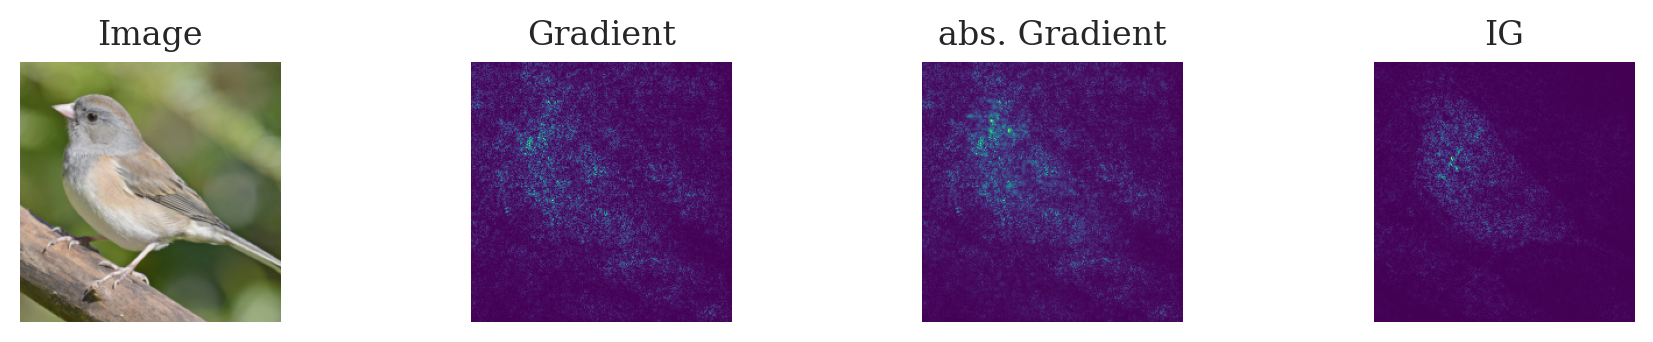

In [13]:
image = load_test_image()
image_preprocessed = preprocess_image(image)
image_preprocessed_norm = normalize_image(image_preprocessed).unsqueeze(0)

model = ImageNetClassifier()

y_pred, y_prob = model.predict(image_preprocessed_norm, return_probs=True)
print(f'Predicted class: "{convert_idx_to_label(y_pred.item())}". Confidence: {y_prob.item() * 100:.2f}%')
assert y_pred == torch.tensor([13])
assert torch.allclose(y_prob, torch.tensor([0.9483]), atol=1e-4)

print('Run `get_custom_gradient` ...')
gradient = get_custom_gradient(model, image_preprocessed_norm.clone())
gradient_abs = get_custom_gradient(model, image_preprocessed_norm.clone(), absolute=True)

print('Run `get_custom_integrated_gradients` ...')
ig = get_custom_integrated_gradients(model, image_preprocessed_norm.clone(), num_samples=50)

print('Run `plot_attributions` ...')
attributions = [gradient, gradient_abs, ig]
attributions = [aggregate_attribution(attr) for attr in attributions]
attributions = [normalize_attribution(attr) for attr in attributions]
plot_attributions(plt, image_preprocessed, attributions, ['Gradient', 'abs. Gradient', 'IG'])
plt.show()